In [1]:
import math
import pandas as pd
import numpy as np
import sklearn.datasets as skds
import matplotlib.pyplot as plt
import seaborn as sns

/Users/akshayprabhakant/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def sign(x):
    return 1 if x>=0 else -1

In [3]:
print(sign(-1));print(sign(0));print(sign(12))

-1
1
1


In [4]:
class Perceptron:
    def __init__(self, in_dim, out_dim, learning_rate = 0.1, weights=None, tol=0.0001):
        self.in_dim=in_dim
        self.out_dim=out_dim
        self.activation = np.vectorize(sign)
        self.learning_rate=learning_rate
        self.tol = tol
        if weights is None:
            # initialize weights as in_dim X out_dim matrix
            self.weights=np.ones((in_dim+1,out_dim))
        else:
            self.weights=weights
            # sanity check
            weights_in, weights_out = self.weights.shape
            if (weights_in != in_dim and weights_in != in_dim+1) or weights_out != out_dim:
                raise Exception("Supplied weight matrix has shape mismatch with either in_dim (and in_dim+1) or out_dim.")

            # check whether bias term exists in given weight matrix
            if self.weights.shape[0] != in_dim+1:
                bias_arr = np.ones((1, out_dim))
                self.weights = np.vstack((self.weights, bias_arr))

    def gradient(self, X, y):
        gradient_mat = np.zeros(self.weights.shape)
        for i in range(X.shape[0]):
            x_i, y_i = X[i, :], y[i]
            f_x_i = self.activation(x_i.dot(self.weights)[0])
            if y_i*f_x_i < 0:
                gradient_mat += -x_i[:, np.newaxis]*y_i
        return gradient_mat

    def weight_update(self, X, y):
        self.weights -= self.learning_rate * self.gradient(X, y)

    def fit(self, X, y, iter=1000):
        # sanity check
        if self.in_dim != X.shape[1]:
            raise Exception("Supplied input matrix X has shape mismatch with either in_dim or in_dim+1 of layer being fit over.")
        if len(y.shape) < 2:
            # 1D np array
            if self.out_dim != 1:
                raise Exception("Supplied target matrix y has shape mismatch with either out_dim of layer being fit over.")
        else:
            if self.out_dim != y.shape[1]:
                raise Exception("Supplied target matrix y has shape mismatch with either out_dim of layer being fit over.")

        x_new = X.copy()
        bias_arr = np.ones((x_new.shape[0], 1))
        x_new = np.hstack((x_new, bias_arr)) # appended bias column vector

        # change 1,0 -> 1,-1
        val_1, val_2 = np.unique(y)
        self.target_encoder = {
            val_1: 1,
            val_2: -1
        }

        self.target_decoder = {
            1: val_1,
            -1: val_2
        }

        # Define a mapping function using lambda and the dictionary
        mapping_function = lambda x: self.target_encoder.get(x, x)
        
        # Use numpy.vectorize to apply the mapping function element-wise
        mapped_y = np.vectorize(mapping_function)(y)
        
        prev_quarter_num = 0
        lr_orig_val = self.learning_rate
        loss_arr = []
        for iter_num in range(iter):
            loss_arr.append(self.loss(X, y))
            quarter_num = int(math.floor((iter_num*4)/iter))
            if quarter_num != prev_quarter_num:
                # block change, reduce learning rate
                self.learning_rate *= 0.9
                print(self.learning_rate)
                prev_quarter_num = quarter_num
            self.weight_update(x_new, mapped_y)
        self.loss_arr = loss_arr
        self.learning_rate = lr_orig_val

    def loss(self, X, y):
        y_pred = self.predict(X) # this will have original data's split.
        
        # convert y_pred and y to -1,1 representation
        mapped_y = np.vectorize(lambda x: self.target_encoder.get(x, x))(y)
        mapped_y_pred = np.vectorize(lambda x: self.target_encoder.get(x, x))(y_pred)
        
        y_i_f = -mapped_y_pred*mapped_y[:, np.newaxis]
        loss_vec_evaluated = np.vectorize(lambda x: max(0, x))(y_i_f)
        return np.sum(loss_vec_evaluated)
      
    def predict(self, X):
        n_samples, n_features = X.shape
        x_new = X.copy()
        if n_features < self.weights.shape[0]:
            # add column of ones to X
            x_new = np.hstack((x_new, np.ones((X.shape[0], 1))))
        
        # Define a reverse mapping function using lambda and the dictionary
        reverse_mapping_function = lambda x: self.target_decoder.get(x, x)
        return np.vectorize(reverse_mapping_function)(self.activation(x_new.dot(self.weights)))

In [5]:
data = skds.load_breast_cancer(as_frame=True)
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [6]:
data.frame.head(10)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,0.07613,...,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0
6,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368,0
7,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510,0
8,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,0.07389,...,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720,0
9,12.46,24.04,83.97,475.9,0.11860,0.23960,0.22730,0.08543,0.2030,0.08243,...,40.68,97.65,711.4,0.1853,1.0580,1.1050,0.2210,0.4366,0.20750,0


In [7]:
X, y = data.data, data.target
display(X.head(5));print(y)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Name: target, Length: 569, dtype: int64


In [8]:
print(y.value_counts())

1    357
0    212
Name: target, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=442)
print(x_train.shape, x_test.shape)

(426, 30) (143, 30)


## Our Implementation
Lets see how our implementation fares.

In [10]:
custom_p = Perceptron(in_dim=x_train.shape[1], out_dim=1, learning_rate = 0.01)
custom_p.fit(x_train, y_train)

0.009000000000000001
0.008100000000000001
0.007290000000000001


In [11]:
y_pred = custom_p.predict(x_test)

In [12]:
print(np.unique(y_pred, return_counts=True))

(array([0, 1]), array([ 43, 100]))


In [13]:
print(custom_p.loss(x_test, y_test))

11


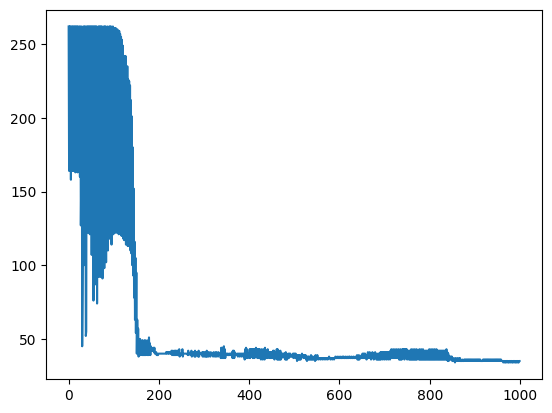

In [14]:
plt.plot(range(len(custom_p.loss_arr)), custom_p.loss_arr)
plt.show()

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)},\nPrecision: {round(precision_score(y_test, y_pred), 3)},\nRecall: {round(recall_score(y_test, y_pred), 3)},\nF1: {round(f1_score(y_test, y_pred), 3)}")

Accuracy: 0.923,
Precision: 0.92,
Recall: 0.968,
F1: 0.944


## scikit-learn's Implementation

In [16]:
from sklearn.linear_model import Perceptron
p = Perceptron()

In [17]:
p.fit(x_train, y_train)

Perceptron()

In [18]:
print(p.score(x_test, y_test))

0.8741258741258742


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred = p.predict(x_test)
print(f"Precision={round(precision_score(y_test, y_pred), 3)}, Recall={round(recall_score(y_test, y_pred), 3)}, F1={round(f1_score(y_test, y_pred), 3)}")

Precision=0.841, Recall=1.0, F1=0.913


Lets look at the loss function and other parameters of this perceptron

In [20]:
print(p.loss_function_)

In [21]:
print(p.get_params())

{'alpha': 0.0001, 'class_weight': None, 'early_stopping': False, 'eta0': 1.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
